# Libs

In [48]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras_metrics import KerasMetrics
from keras.optimizers import adam
import keras.backend as K
from sklearn.metrics import f1_score
from scipy.spatial import distance
import pickle
import lib
%load_ext autoreload
%autoreload 2
opt = adam()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [49]:
corpus = pd.read_csv("Corpus_new_coding/403_verbs_with_classes.csv",index_col="Unnamed: 0")

In [50]:
corpus.head()

,v_inf,v_conj,class
0,preve,$preveju#,class__ver
1,Anteve,$Anteveju#,class__ver
2,interver,$interveju#,class__ver
3,heve,$heveju#,class__ver
4,3ntreve,$3ntreveju#,class__ver


# Features

In [51]:
features = lib.features()

In [52]:
#http://www.ipachart.com/
with open('Files/phones.pickle', 'rb') as file:
    phones = pickle.load(file)

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Test Split

In [22]:
x_test = padded_in[-30:]
y_test = padded_out[-30:]

padded_in = padded_in[:-30]
padded_out = padded_out[:-30]

# Training

In [63]:
model, decoder, history = lib.train(corpus, epochs=300)

InternalError: GPU sync failed

## F1 score Plot

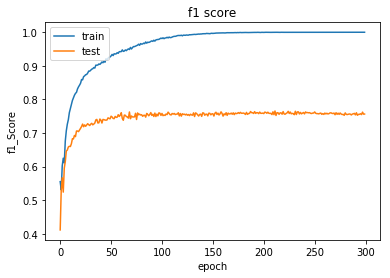

In [50]:
# summarize history for accuracy
plt.plot(history.history['fbeta_score'])
plt.plot(pd.Series(history.history['val_fbeta_score']))
plt.title('f1 score')
plt.ylabel('f1_Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [51]:
history.history['val_fbeta_score'][-1]

0.7563260793685913

## Recall Score Plot

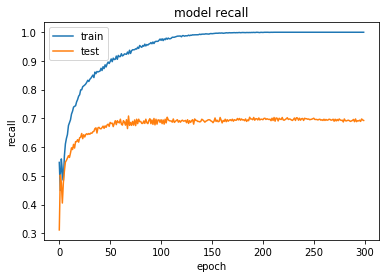

In [52]:
# summarize history for accuracy
score = 'recall'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [53]:
history.history['val_recall'][-1]

0.6927038431167603

## Precision Score Plot

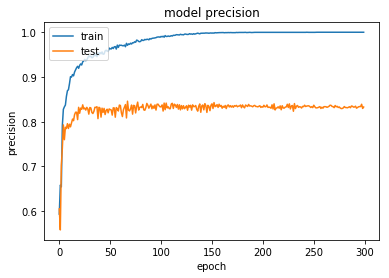

In [54]:
score = 'precision'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [55]:
history.history['val_precision'][-1]

0.8328173160552979

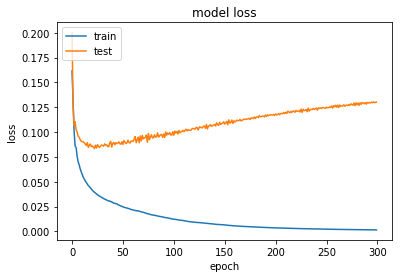

In [56]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Predict

## Euclidean Distance

from scipy.spatial import distance
a = np.array([0,0,1])
b = np.array([0, 0, 1])
dst = distance.euclidean(a, b)
dst

In [57]:
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
import pickle
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays
with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'wb') as file:
    pickle.dump(phone_arrays, file, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'rb') as file:
    phone_arrays = pickle.load(file)

In [60]:
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [62]:
# test if it returns 3
find_closest_array([0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,0,0])

'3'

In [263]:
# test if it returns 3
find_closest_array([0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0])

'#'

In [63]:
# test if it returns a list
find_closest_array([.678, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0])

'p'

 ---

## Inference mode

In [64]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models

encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [254]:
lookup = {}
for phone in phones:
    lookup[phone] = code(phone)    

In [66]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
def reverse_phone(array):
    for item in lookup:
        if np.all(array == lookup[item]):
            return item

In [68]:
coded_in[0][0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [69]:
reverse_phone(coded_in[0][0])

'A'

In [70]:
reverse_phone([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'PAD'

In [255]:
lookup

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [72]:
del lookup['PAD']

In [73]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
#lookup['PAD'] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [285]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'rb') as file:
    lookup = pickle.load(file)
    
def decode_sequence(input_seq, encoder, decoder, renormalize=False):
    # Encode the input as state vectors.
    states_value = encoder.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 21)) # max decoder len = 13, 21 features
    max_decoder_seq_length = 13
    
    #Populate the first character of target sequence with the start character.
    target_seq= lookup['#'].reshape(1, 1, -1)

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_verb = ''
    while not stop_condition:
        output_phones, h, c = decoder.predict(
            [target_seq] + states_value)

        # Sample a phone
        if renormalize:
            sampled_phone = find_closest_array(output_phones[0, -1, :]/omega)
        else:
            sampled_phone = find_closest_array(output_phones[0, -1, :])                                               
        sampled_phone_vector = lookup[sampled_phone]
        decoded_verb += sampled_phone
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_phone == '$' or 
           len(decoded_verb) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = sampled_phone_vector.reshape(1, 1, -1)
#         target_seq = np.zeros((1, 1, num_decoder_tokens))
#         target_seq[0, 0, sampled_phone_vector] = 1.

        # Update states
        states_value = [h, c]

    return decoded_verb[:-1]

def decode_sequences(seq, encoder, decoder, renormalize=False):
    if len(seq.shape) == 3:
        return [decode_sequence(s.reshape(1,*s.shape), encoder, decoder, renormalize=renormalize) for s in seq]
    else:
        return [decode_sequence(seq.reshape(1,*seq.shape), encoder, decoder, renormalize=renormalize)]
    
def decode_from_df(df, encoder, decoder):
    data, coded_in, coded_out, padded_in, padded_out, padded_out_target = preprocessing(df)
    decoded_seqs = decode_sequences(padded_in, encoder, decoder)
    pd.DataFrame(decoded_seqs, index=data.iloc[:,0].tolist()).reset_index()
    return decoded_seqs

# Test

In [77]:
omega = 2*padded_out.mean(axis=0).mean(axis=0)

In [83]:
pd.DataFrame([decode_sequences(x_test), decode_sequences(x_test,True)], columns=input_texts.tolist(), index=['No renorm', 'Renorm']).T

,No renorm,Renorm
sabe,sabu,sabu
ekivale,egili,egeligu
prove,provu,provu
traze,trazu,trazu
pode,pOtu,bOsu
desda,desku,dezku
idea,idiu,adiu
estrea,estreiu,estreiu
da,diu,diu
sobresta,sospretu,sosprAtu


In [84]:
#pd.DataFrame(decode_sequences(padded_in[:10]), corpu9s.inf_verb.tolist()[:10])

,0
Ansia,Anseiu
odia,odeiu
pleitea,pleiteiu
ins3ndia,ins3ndeiu
sortea,sorteiu
hemedia,hemedeiu
intermedia,intermedeiu
media,medeiu
oLa,OLu
koloka,kolOku


# Learning Curve x Train Size

In [30]:
lc = {}
for length in [100, 150, 250, 300, 393]:
    history = train(length)
    lc[length] = history.history['val_fbeta_score'][-1], history.history['recall'][-1], history.history['precision'][-1]

CPU times: user 35min 18s, sys: 3min 47s, total: 39min 5s
Wall time: 11min 20s


In [31]:
lc

{100: (0.5534803867340088, 0.6876574158668518, 0.9181614518165588),
 150: (0.5637180805206299, 0.7294632792472839, 0.9192546606063843),
 250: (0.7961629629135132, 0.8921688175201417, 0.9658581089973449),
 300: (0.7927590012550354, 0.9350285490353902, 0.9777678648630778),
 393: (0.7852533459663391, 0.9763083427574983, 0.9875784125297692)}

with open('WickelfeaturesProject/Files/learning_curve.pickle', 'wb') as file:
    pickle.dump(lc, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('WickelfeaturesProject/Files/lc.pickle', 'rb') as file:
    lc = pickle.load(file)

# Error Analysis

Let's generate a test set that is fair with respesct to the representativity of multiple irregular classes.

# Todo Marcelo

In [ ]:
ls WickelfeaturesProject/

In [244]:
corpus2 = pd.read_csv("WickelfeaturesProject/Corpus_new_coding/403_verbs_with_classes.csv", index_col='Unnamed: 0' )

## Train 0.8 x 0.2

### Train

In [183]:
_, history_new = train(corpus2, length=392, epochs=300)

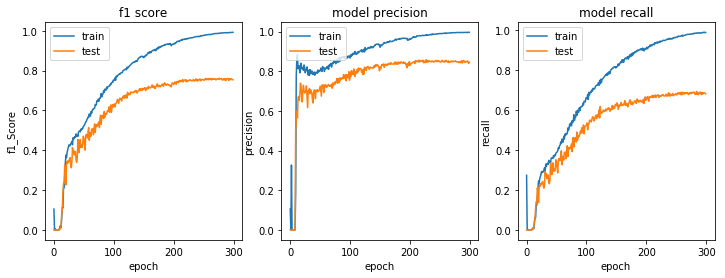

In [184]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
lib.plot_f_beta(history_new)

plt.subplot(1,3,2)
lib.plot_precision(history_new)

plt.subplot(1,3,3)
lib.plot_recall(history_new)

In [176]:
# train old data
history = train(length=392,epochs=300)

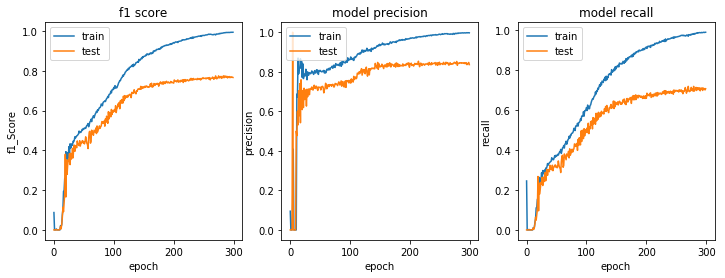

In [180]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plot_f_beta(history)

plt.subplot(1,3,2)
plot_precision(history)

plt.subplot(1,3,3)
plot_recall(history)

In [189]:
corpus2['class'].value_counts()

class__regular    214
class__botar       30
class__seguir      27
class__por         27
class__testar      20
class__fazer       15
class__vir         11
class__ter         10
class__ansiar       9
class__mentir       8
class__pedir        7
class__cobrir       7
class__dizer        7
class__ver          6
class__ler          5
Name: class, dtype: int64

aleatorio com constraints, tem que ter representativos de 5 classes no teste

falar sobre os resultados com verbos q tem mais representatividade (verificar se tem mais da familia trazer por exemplo)

colocar o trazer mais mil vezes pra ver oq acontece

testar "prazer" 

argumentar que o proximo passo seria verificar testar as frequencias reais

revel

# Crazy

In [197]:
from sklearn.model_selection import StratifiedKFold

In [265]:
decode_from_df(corpus2)

['Ansiuu',
 'odiiu',
 'pleiteiu',
 'insinteuu',
 'sorteuu',
 'hemedeiu',
 'intentedeuu',
 'medeiu',
 'oLu',
 'kolOku',
 'insumtu',
 'tOrnu',
 'bu',
 'bOtu',
 'tOku',
 'fOku',
 'mostru',
 'xOru',
 'nOtu',
 'tOstu',
 'truku',
 'hebogu',
 'sOku',
 'kosu',
 'tOmu',
 'hekOrtu',
 'enturtu',
 'enkostu',
 'heturtu',
 'deskubru',
 'hekubru',
 'engulu',
 'enkubru',
 'surtu',
 'digu',
 'hedigu',
 'dez#tuu',
 'kondidu',
 'entredigu',
 'kontradugu',
 'interdigu',
 'perfasu',
 'trAnsfasu',
 'insitesfasu',
 'miifasu',
 'likefasu',
 'benfasu',
 'satisfasu',
 'putrefasu',
 'kontravasu',
 'tohefasu',
 'harefasu',
 'esfasu',
 'desprasu',
 'fasu',
 'adijazu',
 'destreu',
 'heleiu',
 'leiu',
 'kreiu',
 'treleuu',
 'hesintu',
 'persintu',
 'desmintu',
 'presintu',
 'asintu',
 'm3ntu',
 'sintu',
 'konsintu',
 'impesu',
 'pezu',
 'dezimpesu',
 'despitu',
 'mezu',
 'espisu',
 'desmidu',
 'kontrepoNu',
 'dispoNu',
 'trAnspoNu',
 'heditpoNu',
 'espoNu',
 'despoNu',
 'depoNu',
 'suporpoNu',
 'pospoNu',
 'AntepoNu

In [286]:
cv = StratifiedKFold(5)

all_decodings = pd.DataFrame()
for i_train, i_test in cv.split(corpus2, y=corpus2['class']):
    corpus_train, corpus_test = corpus2.iloc[i_train], corpus2.iloc[i_test]
    print(corpus_train.shape, corpus_test.shape)

    model, decoder,  _ = train(corpus_train, epochs=100)
    decoded = decoder(corpus_test)
    
    all_decodings = all_decodings.append(decoded)
    break
# pd.DataFrame(decode_sequences(x_test,True), index=input_texts.tolist())

(317, 3) (86, 3)


ValueError: Shape of passed values is (423, 1), indices imply (86, 1)

In [284]:
decoded

['Anseiu',
 'odeiu',
 'pleiteiu',
 'ins3ndeiu',
 'sorteiu',
 'hemeteiu',
 'interpenbiu',
 'meteiu',
 'OLu',
 'kolugu',
 'infumru',
 'tOrnu',
 'boiu',
 'bOtu',
 'tOku',
 'fOku',
 'mostru',
 'fOru',
 'nOtu',
 'tOstu',
 'trOku',
 'hegubu',
 'sOku',
 'kOsu',
 'tomu',
 'hekOrtu',
 'entOrtu',
 'enkOstu',
 'hetOrnu',
 'deskubru',
 'hekOttu',
 'engulu',
 'enkubru',
 'surtu',
 'digu',
 'hedigu',
 'dezidtu',
 'kondigu',
 'intredegu',
 'kontradigu',
 'interdigu',
 'perfasu',
 'trAnsfasu',
 'insatisfasu',
 'maufasu',
 'likefasu',
 'penfasu',
 'satisfasu',
 'purtefasu',
 'kontrafasu',
 'tohefasu',
 'harefasu',
 'esfasu',
 'desprasu',
 'fasu',
 'adivasu',
 'destetu',
 'heleiu',
 'leiu',
 'kreiu',
 'treleiu',
 'hesintu',
 'persintu',
 'desm3ntu',
 'presintu',
 'asintu',
 'm3ndu',
 'sintu',
 'konsintu',
 'impidu',
 'pEsu',
 'despengu',
 'despitu',
 'midu',
 'espitu',
 'desmidu',
 'kontrapoNu',
 'dispoNu',
 'trAnspoNu',
 'hedispoNu',
 'espoNu',
 'despoNu',
 'depoNu',
 'superpoNu',
 'pospoNu',
 'antepoN

In [281]:
all_decodings

,0
0,e
1,e
2,e
3,e
4,e
5,e
6,e
7,e
8,e
9,e


In [209]:
decoded = pd.DataFrame(decode_sequences(x_test,True), index=input_texts.tolist()).reset_index()
decoded.columns=['orig', 'dec']

In [233]:
decoded['group']= decoded.orig.map(corpus2.set_index('v_inf')['class'])

In [246]:
(corpus2.v_inf=='korta').sum()

1

In [230]:
(corpus.inf_verb =='korta').sum()

1

In [214]:
decoded

,orig,dec,group
0,sabe,vabu,NaN
1,ekivale,ageliju,NaN
2,prove,brovu,NaN
3,traze,draju,NaN
4,pode,bOhu,NaN
5,desda,dezku,NaN
6,idea,adiu,NaN
7,estrea,estrau,NaN
8,da,Odu,NaN
9,sobresta,zorpErsu,NaN
